petgraph review: internals
---------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 11.2019
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/petgraph/petgraph) [ipynb](./petgraph_review.ipynb)

petgraph is a rust library which allows you to work with graph data structures in rust.

In [2]:
:dep petgraph = "0.4.13"
:dep petgraph-evcxr = "*"

Internal representation of graphs by petgraph
------------------------------------------------------------------

This is the second part on a series about working with graphs in rust. The first part can be found [here](https://thobbs.cz/rust-play/petgraph_review.html).

Petgraph supports four different internal representations for graphs. The most common one is `Graph` which I have used throughout this tutorial.

- [`Graph`](https://docs.rs/petgraph/0.4.13/petgraph/graph/index.html) 
- [`StableGraph`](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
- [`GraphMap`](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
- [`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)

The `Graph` data structure
--------------------------------------

`Graph`s are stored like this:

```rust
pub struct Graph<N, E, Ty = Directed, Ix = DefaultIx> {
    nodes: Vec<Node<N, Ix>>,
    edges: Vec<Edge<E, Ix>>,
    ty: PhantomData<Ty>,
}
```
...

```rust
pub struct Node<N, Ix = DefaultIx> {
    /// Associated node data.
    pub weight: N,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
}
```
...

```rust
pub struct Edge<E, Ix = DefaultIx> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    node: [NodeIndex<Ix>; 2],
}
```
...

My first impression when looking at this code was "wait which order is the 'outgoing and incoming edge list' so I looked in the source code and found that there is actually an enum which indexes the duple. It can be found in [src/lib.rs](https://github.com/petgraph/petgraph/blob/45e8d931a786f0ab928aff6fa602fab4e418dbb8/src/lib.rs#L123).

```rust
pub enum Direction {
    /// An `Outgoing` edge is an outward edge *from* the current node.
    Outgoing = 0,
    /// An `Incoming` edge is an inbound edge *to* the current node.
    Incoming = 1
}
```

Basically, what is going on, is that each `Node` has two doubly linked lists of `Edge`s associated with it. Now my next question, is how does a `Directed` Graph differ from an `Undirected` one in terms of internal representation?

I could have read the source code to figure that out, but I decided to have fun and instead visualize the datastructure by converting it to a graph.

In [3]:
/*
  In order to visualize the internals we need to make a bunch of fields public.
  We do so via an unsafe cast, refered to as a transumtation in rust.
  This method is described here:
  https://users.rust-lang.org/t/is-private-really-private/7826/15
*/
extern crate petgraph;
use petgraph::*;
use petgraph::dot::Dot;
use petgraph::graph::*;
use petgraph::prelude::*;
use petgraph::data::*;
use std::marker::PhantomData;
use petgraph_evcxr::draw_graph;

pub struct PubNode<N, Ix> {
    pub weight: N,
    pub next: [EdgeIndex<Ix>; 2],
}

pub struct PubEdge<E, Ix = u64> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    pub next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    pub node: [NodeIndex<Ix>; 2],
}

pub struct PubGraph<N, E, Ty = Directed, Ix = u64> {
    pub nodes: Vec<PubNode<N, Ix>>,
    pub edges: Vec<PubEdge<E, Ix>>,
    pub ty: PhantomData<Ty>,
}

fn visualize_graph_internals<N, E, Ty, Ix>(g: &Graph<N, E, Ty, Ix>) -> Graph<String, String, petgraph::Directed>
    where
        N: std::fmt::Debug + Clone,
        E: std::fmt::Debug + Clone,
        Ty: EdgeType + Clone,
        Ix: std::fmt::Debug + IndexType + Clone,
{
    let mut v: Graph<String, String, petgraph::Directed> = Graph::new();
    let mut _g: Graph<N, E, Ty, Ix> = g.clone();
    let pub_g: PubGraph<N, E, Ty, Ix> = unsafe { std::mem::transmute(_g) };
    let mut nodes: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    let mut edges: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    for node_id in g.node_indices() {
        let w = format!("Node: {:?}", g.node_weight(node_id).unwrap());
        nodes[node_id.index()] = v.add_node(w.to_string());
    }
    for edge_id in g.edge_indices() {
        let w = format!("Edge: {:?}", g.edge_weight(edge_id).unwrap());
        edges[edge_id.index()] = v.add_node(w.to_string());
    }
    let mut add_link = |start: NodeIndex, end: usize, collection: Vec<NodeIndex>, label: &str| {
        match collection.get(end) {
            Some(dest) => {
                v.add_edge(start, *dest, label.to_string());
            },
            None => {
                let end_node = v.add_node("end".to_string());
                v.add_edge(start, end_node, label.to_string());
            },
        }
    };
    for (edge, edge_id) in pub_g.edges.iter().zip(g.edge_indices()) {
        let vedge_id = edges[edge_id.index()];
        add_link(vedge_id, edge.node[0].index(), nodes.clone(), "nodes[0]");
        add_link(vedge_id, edge.node[1].index(), nodes.clone(), "nodes[1]");
        add_link(vedge_id, edge.next[0].index(), edges.clone(), "next[0]");
        add_link(vedge_id, edge.next[1].index(), edges.clone(), "next[1]");
    }
    for (node, node_id) in pub_g.nodes.iter().zip(g.node_indices()) {
        let vnode_id = nodes[node_id.index()];
        add_link(vnode_id, node.next[0].index(), edges.clone(), "next[0]");
        add_link(vnode_id, node.next[1].index(), edges.clone(), "next[1]");
    }
    v
}

First lets look at an undirected graph; the `list` example from [the previous article](./petgraph_review.html).

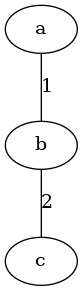

In [4]:
let mut list : Graph<&str, &str, petgraph::Undirected> = Graph::new_undirected();
let item1 = list.add_node("a");
let item2 = list.add_node("b");
let item3 = list.add_node("c");
list.add_edge(item1, item2, "1");
list.add_edge(item2, item3, "2");
draw_graph(&list);

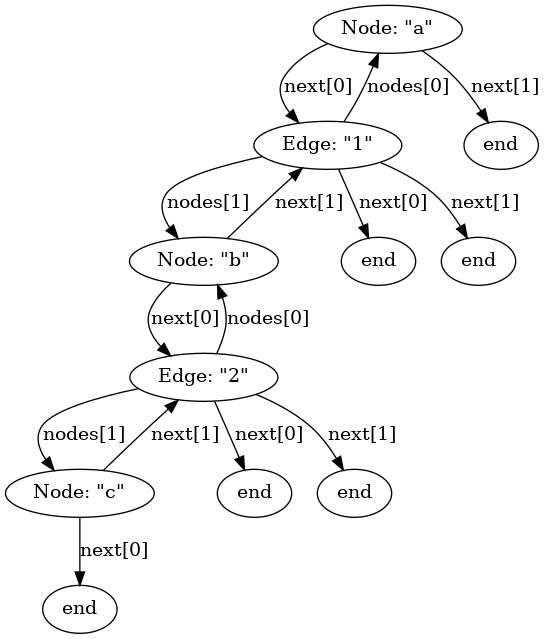

In [5]:
draw_graph(&visualize_graph_internals(&list));

Now lets look at a directed graph. I'll use the `tree` example.

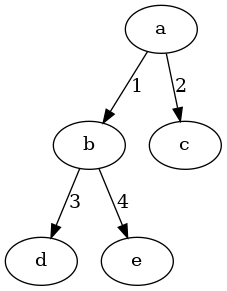

In [6]:
let mut tree : Graph<&str, &str, petgraph::Directed> = Graph::new();
let tree_item1 = tree.add_node("a");
let tree_item2 = tree.add_node("b");
let tree_item3 = tree.add_node("c");
let tree_item4 = tree.add_node("d");
let tree_item5 = tree.add_node("e");
tree.add_edge(tree_item1, tree_item2, "1");
tree.add_edge(tree_item1, tree_item3, "2");
tree.add_edge(tree_item2, tree_item4, "3");
tree.add_edge(tree_item2, tree_item5, "4");
draw_graph(&tree);

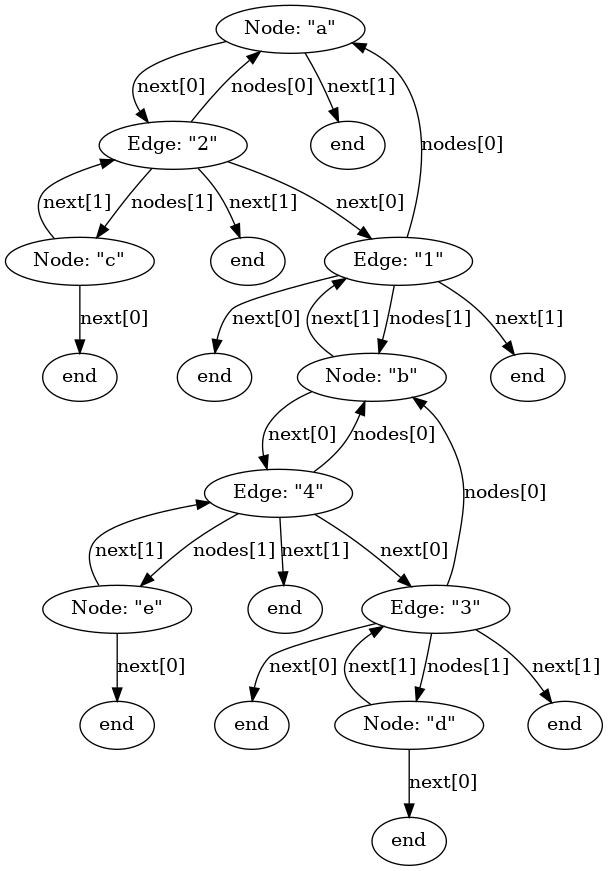

In [7]:
draw_graph(&visualize_graph_internals(&tree));

As you can see, directed and undirected graphs have the exact same internal representation.

To answer a question from earier "how do we convert from a directed to an undirected graph?" We can do so "unsafely" simply by using transmute.

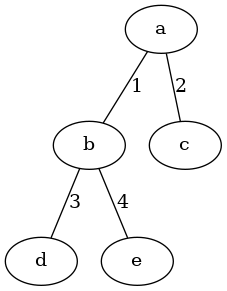

In [8]:
let undirected_tree : Graph<&str, &str, petgraph::Undirected> = unsafe {std::mem::transmute(tree.clone())};
draw_graph(&undirected_tree);

Of course, since we did a transmute and it worked, we know that the representation *should* be the same, lets just verify that.

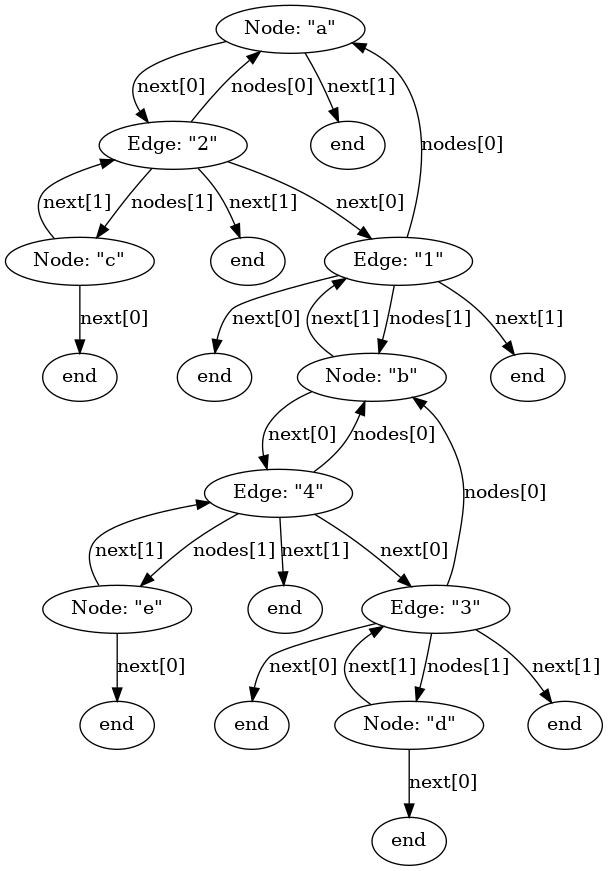

In [9]:
draw_graph(&visualize_graph_internals(&undirected_tree));

I'd like to point out some interesting consiquences of this data structure choice. One is that the doubly linked list of edges means that some nodes are "farther" from eachother than others in the data structure even though their theoretical distance is the same.

The distances between A → B and A → C are both 1 in the origional tree, but in the data structure, the distance from A → B is greater than that of A → C:

In [10]:
use std::collections::HashMap;
use petgraph::algo::*;

let udt_internals = visualize_graph_internals(&undirected_tree);
{
    fn print_path(
        g: &Graph<String, String, Directed>,
        start: &str,
        end: &str,
    ){
        let mut nodes: HashMap<&str, NodeIndex> = HashMap::new();
        for i in g.node_indices() {
            nodes.insert(g.node_weight(i).unwrap(), i);
        }
        let atob = astar(
            g,
            *nodes.get(start).unwrap(),
            | id | { *nodes.get(end).unwrap() == id },
            | _ | 0,
            | _ | 0,
        );
        let atobv = atob.unwrap().1;
        let atob_human: Vec<String> = atobv
            .iter()
            .map(| i | g.node_weight(*i).unwrap().clone())
            .collect();
        println!("Path from [{}] → [{}]:\n\t[{}]", start, end, atob_human.join("] → ["));        
    }
    print_path(&udt_internals, "Node: \"a\"", "Node: \"b\"");
    print_path(&udt_internals, "Node: \"a\"", "Node: \"c\"");
}

Path from [Node: "a"] → [Node: "b"]:
	[Node: "a"] → [Edge: "2"] → [Edge: "1"] → [Node: "b"]
Path from [Node: "a"] → [Node: "c"]:
	[Node: "a"] → [Edge: "2"] → [Node: "c"]


()

What are graphs and how should they be serialized?
----------------------------------------------------------------------------

When I open a text book on graph theory, perhaps "Graph Theory 4th edition Reinhard Diestel" I find a curios definition of a graph: "A *graph* is a pair G = (V, E) of sets such that E ⊆ \[V\]²; thus, the elements of E are 2-element subsets of V." Basically, what this means that in rust a graph is:

In [11]:
use std::hash::Hash;
use std::collections::HashSet;

pub struct MathGraph<T> {
    pub v: HashSet<T>,
    // pub e: HashSet<HashSet<T>>, Using a tuple is easier
    pub e: HashSet<(T, T)>,
}

impl<T: Hash + Eq + Copy> MathGraph<T> {
    pub fn get_matrix_square_of_v(&self) -> HashSet<(T,T)> {
        let mut res: HashSet<(T,T)> = HashSet::new();
        for vertex_a in self.v.iter() {
            let v_as_vec: Vec<_> = self.v.iter().collect();
            for vertex_b in v_as_vec.iter().rev() {
                res.insert((vertex_a.clone(), *vertex_b.clone()));
            }
        }
        res
    }
    
    pub fn valid(&self) -> bool {
        let matrix_square_of_v = self.get_matrix_square_of_v();
        for edge in self.e.iter() {
            if !matrix_square_of_v.contains(edge) {
                return false;
            }
        }
        return true;
    }
}

In [12]:
{
    let mut v: HashSet<usize> = HashSet::new();
    let mut e: HashSet<(usize, usize)> = HashSet::new();
    v.insert(1);
    v.insert(2);
    e.insert((1, 2));    
    let mut valid_example = MathGraph{
        v: v,
        e: e,
    };

    println!("Is valid graph? {:?}", valid_example.valid());
}

Is valid graph? true


()

In [13]:
{
    let mut v: HashSet<usize> = HashSet::new();
    let mut e: HashSet<(usize, usize)> = HashSet::new();
    v.insert(1);
    v.insert(2);
    e.insert((1, 3));    
    let mut invalid_example = MathGraph{
        v: v,
        e: e,
    };

    println!("Is valid graph? {:?}", invalid_example.valid());
}

Is valid graph? false


()

Diestel's graphs are in some ways profoundly uninteresting. In the previous article, I wrote about various applications of graph theory in real life; computer networks, electrical grids, dependency DAGs, interstate tarrif and tax calculations ect. None of these systems or structures consist of one set of vertexes and another **separate** set of edges in which the edges are two element subsets of the vertexes. Instead, these graphs all consist of vertexes which have edges attached to them. An edge from A → B is closer to vertex A than it is to another edge from D → E. Indeed, in a way, Diestel's "graphs" are not graphs at all, their just two sets.

Instead, I would like to propose a different definition of "graph".

"A *graph* is **any** descrete structure or system who's structure could be described using a pair G = (V, E) of sets such that E ⊆ \[V\]²; thus, the elements of E are 2-element subsets of V. Graph theory is the study of the common principles and algorithms which can be applied to such structures."

There are several differences between petgraph's `Graph` data structure and Diestel's "graph". First, Diestel's graph does not allow for there to be multiple edges between the same two nodes in any given direction. This is because the edge list is a set, and every element in a set must be unique. Secondly, in petgraph, edges may have values (weights) associated with them.

Both Diestel and petgraph represent graphs as two collections (vertexes and edges). It seemed to me, that the relatively large number of pointers, and the fact that you have to keep on jumping back and forth between the Vertex list and the Edge list makes this structure inefficient. Wouldn't it be more efficient if the Edges that belonged to a Vertex were stored *with* that vertex? That would be graphier, and it would require less jumping back and forth.

Interestingly, the [very first](https://github.com/petgraph/petgraph/blob/6fdf817363b5555a91a3a9012cff5d317c590590/src/bin.rs#L65) petgraph commit defined graphs as follows:

```rust
pub struct DiGraph<N: Eq + Hash, E> {
    nodes: HashMap<N, Vec<(N, E)>>,
}
```

Which is basically what I imagine to be the natural structure for a graph. Except, this limits what can be stored as node weights.

Imagine if `Graph` was defined as:

In [14]:
:dep tinyset = "0.0.3"

In [15]:
use tinyset::VecSet;

pub struct TimGraph<N, E, Ty = Directed> {
    pub nodes: Vec<TimNode<N, E>>,
    pub ty: PhantomData<Ty>,
}

pub struct TimNode<N, E> {
    /// Associated node data.
    pub weight: N,
    /// Nodes with incoming edges
    pub incomming: VecSet<usize>,
    /// Outgoing edges
    pub outgoing: Vec<(usize, E)>,
}

This would also ensure that equadistant vertexes would always be equadistant in the underlying data structure. In all cases, it should reduce the number of hops required when traversing the graph. 

Recal this graph of moravia:

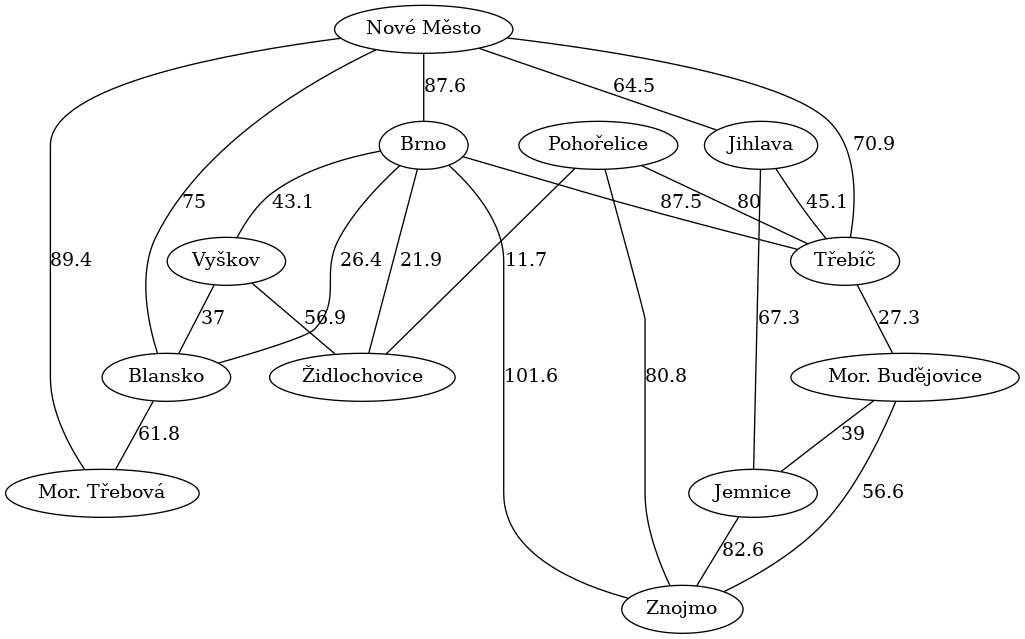

In [16]:
let mut moravia : Graph<&str, f32, petgraph::Undirected> = Graph::new_undirected();
let brno = moravia.add_node("Brno");
let zdlch = moravia.add_node("Židlochovice");
let pohor = moravia.add_node("Pohořelice");
let vysko = moravia.add_node("Vyškov");
let blansk = moravia.add_node("Blansko");
let trebic = moravia.add_node("Třebíč");
let mbud = moravia.add_node("Mor. Buďějovice");
let jihl = moravia.add_node("Jihlava");
let jemn = moravia.add_node("Jemnice");
let znojmo = moravia.add_node("Znojmo");
let novmest = moravia.add_node("Nové Město");
let mtreb = moravia.add_node("Mor. Třebová");
moravia.add_edge(brno, trebic, 87.5);
moravia.add_edge(brno, zdlch, 21.9);
moravia.add_edge(brno, vysko, 43.1);
moravia.add_edge(brno, blansk, 26.4);
moravia.add_edge(pohor, zdlch, 11.7);
moravia.add_edge(pohor, trebic, 80.0);
moravia.add_edge(blansk, mtreb, 61.8);
moravia.add_edge(trebic, mbud, 27.3);
moravia.add_edge(mbud, znojmo, 56.6);
moravia.add_edge(brno, znojmo, 101.6);
moravia.add_edge(mbud, jemn, 39.0);
moravia.add_edge(jihl, trebic, 45.1);
moravia.add_edge(jihl, jemn, 67.3);
moravia.add_edge(jemn, znojmo, 82.6);
moravia.add_edge(pohor, znojmo, 80.8);
moravia.add_edge(novmest, jihl, 64.5);
moravia.add_edge(novmest, brno, 87.6);
moravia.add_edge(novmest, trebic, 70.9);
moravia.add_edge(novmest, blansk, 75.0);
moravia.add_edge(novmest, mtreb, 89.4);
moravia.add_edge(vysko, blansk, 37.0);
moravia.add_edge(vysko, zdlch, 56.9);
draw_graph(&moravia);

Lets convert this graph to the new proposed implementation.

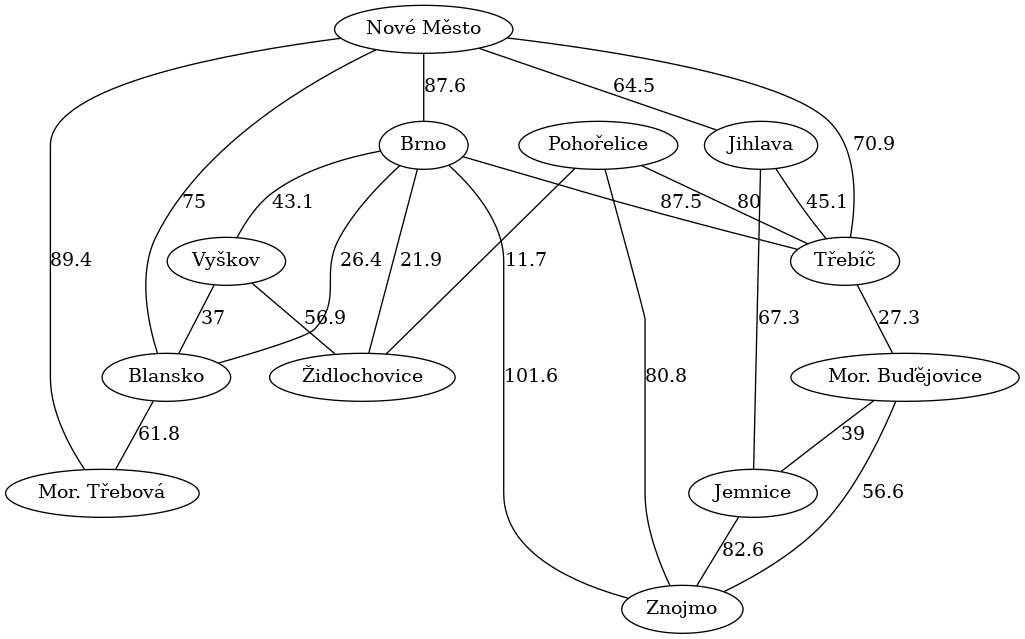

In [17]:
use petgraph_evcxr::draw_dot;
use std::fmt::{self, Display, Write};
use petgraph::graph::*;

fn graph_to_timgraph<N, E, Ty, Ix>(g: &Graph<N, E, Ty, Ix>) -> TimGraph<N, E, Ty> 
where
    Ty: EdgeType,
    Ix: IndexType,
    E: Clone,
    N: Clone,
{
    let mut tg: TimGraph<N, E, Ty> = TimGraph {
        nodes: Vec::with_capacity(g.node_count()),
        ty: PhantomData,
    };
    for nodei in g.node_indices() {
        tg.nodes.push(TimNode {
            weight: g.node_weight(nodei).unwrap().clone(),
            incomming: VecSet::new(),
            outgoing: Vec::new(),
        });
    }
    for edge in g.raw_edges().iter() {
        tg.nodes[edge.target().index()].incomming.insert(edge.source().index());
        tg.nodes[edge.source().index()].outgoing.push((edge.target().index(), edge.weight.clone()));
    }
    tg
}

fn draw_timgraph<N, E, Ty>(g: &TimGraph<N, E, Ty>)
    where
        Ty: EdgeType,
        N: Display,
        E: Display + Copy,
{
    let mut dot = String::new();
    let mut edges = String::new();
    if Ty::is_directed() {
        dot.push_str("digraph");
    } else {
        dot.push_str("graph");
    }
    dot.push_str("{\n");
    for (i, node) in g.nodes.iter().enumerate() {
        dot.push_str(&format!("\t{} [label=\"{}\"]\n", i, node.weight)); //TODO escape labels
        for edge in node.outgoing.iter() {
            let dir;
            if Ty::is_directed() {
                dir = "->";
            } else {
                dir = "--";
            }
            edges.push_str(&format!("\t{} {} {} [label=\"{}\"]\n", i, dir, edge.0, edge.1));
        }
    }
    dot.push_str(&edges);
    dot.push_str("}");
    draw_dot(dot);
}

let tim_moravia = graph_to_timgraph(&moravia);

draw_timgraph(&tim_moravia);

Determining the in memory size of a nested data structure in rust programatically appears to not be trivial, unfortunately, but here we can see a comparison done by hand.

Note: I use `u64` in place of `usize` due to an apparent bug in evcxr which sometimes replaces `usize` with `u32` despite runnning a 64 bit system.

In [18]:
use std::mem;
fn print_sizes(node_count: usize, edge_count: usize) {
    println!(
        "TimGraph {} bytes\n TimNode {} bytes {{ weight {} bytes incomming {} bytes outgoing {} bytes }} * num nodes {} = {} bytes\n u64 * num edges {} = {} bytes\n (u64, f32) {} bytes * num edges {} = {} bytes\nTotal: {} bytes (+ the size of the vertex labels)\n\n",
        mem::size_of::<TimGraph<&str, f32>>(),
        mem::size_of::<TimNode<&str, f32>>(),
        mem::size_of::<&str>(),
        mem::size_of::<VecSet<u64>>(),
        mem::size_of::<Vec<(u64, f32)>>(),
        node_count,
        node_count * mem::size_of::<TimNode<&str, f32>>(),
        edge_count,
        edge_count * mem::size_of::<u64>(),
        mem::size_of::<(u64, f32)>(),
        edge_count,
        mem::size_of::<(u64, f32)>() * edge_count,
        mem::size_of::<TimNode<&str, f32>>() * node_count + mem::size_of::<(u64, f32)>() * edge_count + mem::size_of::<u64>() * edge_count,
    );

    println!(
        "Graph {} bytes\n Node {} bytes * num nodes {} = {} bytes\n Edge {} bytes * num edges {} = {} bytes\nTotal: {} bytes (+ size of the vertex labels)\n\n",
        mem::size_of::<Graph<&str, f32, petgraph::Undirected, u64>>(),
        mem::size_of::<Node<&str, u64>>(),
        node_count,
        mem::size_of::<Node<&str, u64>>() * node_count,
        mem::size_of::<Edge<f32, u64>>(),
        edge_count,
        mem::size_of::<Edge<f32, u64>>() * edge_count,
        mem::size_of::<Node<&str, u64>>() * node_count + mem::size_of::<Edge<f32, u64>>() * edge_count,
    );
}
println!("Statistics for map of Moravia.");
print_sizes(moravia.node_count(), moravia.edge_count());
println!("Statistics for singly linked list in graph form.");
print_sizes(5, 4);
println!("Statistics for complete(star) graph with 150 nodes.");
print_sizes(150, (150*149)/2);

Statistics for map of Moravia.
TimGraph 24 bytes
 TimNode 64 bytes { weight 16 bytes incomming 24 bytes outgoing 24 bytes } * num nodes 12 = 768 bytes
 u64 * num edges 22 = 176 bytes
 (u64, f32) 16 bytes * num edges 22 = 352 bytes
Total: 1296 bytes (+ the size of the vertex labels)


Graph 48 bytes
 Node 32 bytes * num nodes 12 = 384 bytes
 Edge 40 bytes * num edges 22 = 880 bytes
Total: 1264 bytes (+ size of the vertex labels)


Statistics for singly linked list in graph form.
TimGraph 24 bytes
 TimNode 64 bytes { weight 16 bytes incomming 24 bytes outgoing 24 bytes } * num nodes 5 = 320 bytes
 u64 * num edges 4 = 32 bytes
 (u64, f32) 16 bytes * num edges 4 = 64 bytes
Total: 416 bytes (+ the size of the vertex labels)


Graph 48 bytes
 Node 32 bytes * num nodes 5 = 160 bytes
 Edge 40 bytes * num edges 4 = 160 bytes
Total: 320 bytes (+ size of the vertex labels)


Statistics for complete(star) graph with 150 nodes.
TimGraph 24 bytes
 TimNode 64 bytes { weight 16 bytes incomming 24 byte

Storing edge lists with nodes is more efficient when there are lots of edges, such as in complete or nearly complete graphs. This is because fewer index's (references) are necessary. However, when there aren't many edges the petgraph "adjacency list" model wins out because all those Vectors I used to store the edges with the nodes aren't exactly free. In rust, a vector consists of a pointer `usize` a length `usize` and a capacity `usize`. Since my implementation stores two vectors of edges per node, when there are few edges and many nodes my implementation takes more space. This extra space usage could be eliminated by using non-standard vector types and other dirty tricks, but it cannot be done cleanly.

Perhaps as importantly than the size the graph takes up in memory is the number of heap allocations required when initiallizing a graph of known size. Since my implementation requires two Vecs per node, you have `O(2*n)` heap allocations. Where-as with the petgraph implementation you have `O(2)` allocations. Petgraph is clearly superior in this case, and it is common to know the size of the graph when initializing it, because methods that return new graphs which are the same size as the old (specifically `map`) are quite common.

Another disadvantage of my structure is that it is harder to refer to an edge. In petgraph's model, edges can be refered to as a single usize, where-as in mine you require two numbers, a node id and an edge id.

Lets do a speed test, simply cloning TimGraphs and Graphs, to see which is faster.

In [19]:
impl<N, E, Ty> Clone for TimGraph<N, E, Ty>
    where N: Clone, E: Clone,
{
    fn clone(&self) -> Self {
        TimGraph {
            nodes: self.nodes.clone(),
            ty: self.ty,
        }
    }

    fn clone_from(&mut self, rhs: &Self) {
        self.nodes.clone_from(&rhs.nodes);
        self.ty = rhs.ty;
    }
}

impl<N, E> Clone for TimNode<N, E>
    where N: Clone, E: Clone,
{
    fn clone(&self) -> Self {
        TimNode {
            weight: self.weight.clone(),
            incomming: self.incomming.clone(),
            outgoing: self.outgoing.clone(),
        }
    }

    fn clone_from(&mut self, rhs: &Self) {
        self.weight = rhs.weight.clone();
        self.incomming.clone_from(&rhs.incomming);
        self.outgoing.clone_from(&rhs.outgoing);
    }
}

In [20]:
use std::time::{Duration, Instant};
let clone_count = 100000;
{
    let now = Instant::now();
    for n in (0..clone_count) {
        &tim_moravia.clone();
    }
    println!("TimGraph::clone() {} times: {} ms", clone_count, now.elapsed().as_millis());
};
{
    let now = Instant::now();
    for n in (0..clone_count) {
        &moravia.clone();
    }
    println!("Graph::clone() {} times: {} ms", clone_count, now.elapsed().as_millis());
}

TimGraph::clone() 100000 times: 72 ms
Graph::clone() 100000 times: 13 ms


()

Petgraph's algorithms are all generic, working with traits rather than being bound to any given data structure. I wanted to analize the performance difference for graph traversal algorithms as well, but I found that there are just far too many traits to be implemented in an afternoon, so I gave up.


[StableGraph](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
------------------

When a node or edge in a `Graph` gets deleted, the `Vec`s of nodes and edges are repacked. This means that the indexes of all the nodes and edges which came after the deleted nodes and edges are invalidated. `StableGraph` solves this problem through some rather cleaver but dirty tricks.

```rust
pub struct StableGraph<N, E, Ty = Directed, Ix = DefaultIx>
{
    g: Graph<Option<N>, Option<E>, Ty, Ix>,
    node_count: usize,
    edge_count: usize,

    // node and edge free lists (both work the same way)
    //
    // free_node, if not NodeIndex::end(), points to a node index
    // that is vacant (after a deletion).  The next item in the list is kept in
    // that Node's Node.next[0] field. For Node, it's a node index stored
    // in an EdgeIndex location, and the _into_edge()/_into_node() methods
    // convert.
    free_node: NodeIndex<Ix>,
    free_edge: EdgeIndex<Ix>,
}
```

When you delete a node in a stable graph, first, it disconnects the edge/node from the graph, then it marks the node/edge weight as `None`. `StableGraph`'s methods which do things such as iterating all nodes will ignore those who's weights are `None`. `StableGraph` stores a list of such "free" nodes/edges embeded in the graph as described in the comment.

[GraphMap](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
---------------

`GraphMap` aims to make it easy and fast to look up Nodes by their weights.

```rust
pub struct GraphMap<N, E, Ty> {
    nodes: OrderMap<N, Vec<(N, CompactDirection)>>,
    edges: OrderMap<(N, N), E>,
    ty: PhantomData<Ty>,
}
```

This works decently if `size_of::<N>` is small. But if it is large, there is a rather absurd amount of duplicated data. The whole structure takes:


```
(4 * size_of::<N>() + size_of::<E>() + 2 * size_of::<CompactDirection>() ) * |E| + size_of::<N>() * |V|
```

space.

An alternative design would be:

In [21]:
use std::collections::*;

pub struct TimsGraphMapNode<N, E> {
    outgoing_edges: Vec<(N, E)>,
    nodes_that_point_here: VecSet<N>,
}

pub struct TimsGraphMap<N, E, Ty> {
    nodes: HashMap<N, TimsGraphMapNode<N, E>>,
    ty: PhantomData<Ty>,
}


This would support multigraphs, it would take at most the same number of OrderMap lookups to resolve an edge weight, but most of the time fewer lookups. It would take the following amount of space:

```
( 2 * size_of::<N>() + size_of::<E>() ) * |E| + size_of::<N>() * |V|
```

Even so, data-duplication cannot be avoided.

That said. If `size_of::<N>()` is small, you may find `GraphMap` usefull if you often need to look up Nodes by their node weight.

[`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)
---------------------

Any graph that does not contain [parallel edges](https://en.wikipedia.org/wiki/Multigraph) can be represented as an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). Parallel edges are marked in red.

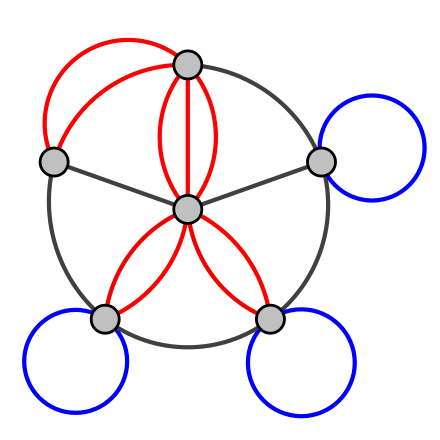

(This image is from Wikipedia and licensed under the [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license)

Remember how Diestel defined a graph as "A *graph* is a pair G = (V, E) of sets such that E ⊆ \[V\]²; thus, the elements of E are 2-element subsets of V."? Well an adjancency matrix is a matrix in the shape of \[V\]² filled with either 1's or 0's depending on whether the edge is present in the graph. That's really hard to visualize so lets draw that out.

Say I have a graph with 3 nodes A, B, C.

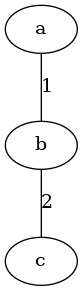

In [22]:
draw_graph(&list);

Lets draw an adjacency matrix for this graph.

First we'll start by drawing \[V\]²

|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**|| A→A | A→B | A→C |
|**B**|| B→A | B→B | B→C |
|**C**|| C→A | C→B | C→C |

And now we'll fill in our adjacency matrix:

|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**|| 0   | 1   | 0   |
|**B**|| 1   | 0   | 1   |
|**C**|| 0   | 1   | 0   |

We have an edge from A→B and and edge from A→C. Since the graph is undirected, we also mark B→A and C→B as connected. Otherwise, all the values in the matrix are 0.

We can also draw the matrix filling in edge weights for the values and leaving the other cells blank.

|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**|| 0   | 1   | 0   |
|**B**|| 1   | 0   | 2   |
|**C**|| 0   | 2   | 0   |

For the most part, storing graphs as raw adjancency matrices is very inefficent. Most of the time, most of your matrix is empty. However, with the compressed sparse row method of storing adjanceny matrices we can leave those blank cells out. Using sparce adjancency matrices is efficient in cases where:

1. you don't need parallel edges
2. You aren't going to be adding or removing edges very frequently. Adding edges with CSR costs O( |E| + |V| ) where as it is only O(1) for Graph.

Benchmarking is always the real source of truth but chances are hight that CSR is going to be a good choice if you fulfill those conditions. The fact that petgraph's CSR implementation is also less complete than the other internal representations may also play a role. YMMV.

Time complexity for various graph representations can be found [here](https://people.csail.mit.edu/hjxu/papers/pcsr.pdf). Some benchmarks are [here](https://pdfs.semanticscholar.org/57ab/ed66216252569de8c7227bdb6e0aaf6e9647.pdf).

So how does CSR work? I tried reading [the wikipedia article](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_\(CSR,_CRS_or_Yale_format\)) on it and got no-where.

Luckly, there is a [1 minute long Udacity video](https://www.youtube.com/watch?v=Qi7FcjN7nsc) which clears things up nicely.

Petgraph stores CSR graphs in the following structure:

```rust
#[derive(Debug)]
pub struct Csr<N = (), E = (), Ty = Directed, Ix = DefaultIx> {
    /// Column of next edge
    column: Vec<NodeIndex<Ix>>,
    /// weight of each edge; lock step with column
    edges: Vec<E>,
    /// Index of start of row Always node_count + 1 long.
    /// Last element is always equal to column.len()
    row: Vec<usize>,
    node_weights: Vec<N>,
    edge_count: usize,
    ty: PhantomData<Ty>,
}
```

This structure differs from the one described in the udacity video only in that `row` contains and extraneous element which equals `column.len()`. This extraneous element is also described in the wikipedia article, and exists purely for the sake of wasting memory and making things more complex. Ignore it, or better yet send in a PR to get rid of it, it shouldn't be there!

I start by recreating the A → B → C list example as a Csr graph.

In [30]:
use petgraph::csr;
let mut csr_list : petgraph::csr::Csr<&str, &str, petgraph::Undirected> = petgraph::csr::Csr::new();
{
    let csr_item1 = csr_list.add_node("a");
    let csr_item2 = csr_list.add_node("b");
    let csr_item3 = csr_list.add_node("c");
    csr_list.add_edge(csr_item1, csr_item2, "1");
    csr_list.add_edge(csr_item2, csr_item3, "2");
}
println!("{:?}", csr_list);

Csr { column: [1, 0, 2, 1], edges: ["1", "1", "2", "2"], row: [0, 1, 3, 4], node_weights: ["a", "b", "c"], edge_count: 2, ty: PhantomData }


()

How do we rebuild the adjancency matrix from this?

We start by lining up `edges` and `column`.

| index      | 0   | 1   | 2   | 3   |
|------------|-----|-----|-----|-----|
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |

Then we'll chop off the extrenious last element of row to get `row: [0, 1, 3]` and we'll fill in linebreak symbols at each index in `row`.

| index      | 0   | 1   | 2   | 3   |
|------------|-----|-----|-----|-----|
| **new_row**| ↪   | ↪   |     | ↪   |
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |

Now we create an empty adjanceny matrix.

|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     |     |     |
|**B**||     |     |     |
|**C**||     |     |     |

In our CSR table we read the 0th column and fill in the edge at the listed column in the 0th row.

| index      | \*0 | 1   | 2   | 3   |
|------------|-----|-----|-----|-----|
| **new_row**| ↪   | ↪   |     | ↪   |
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |


|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     | "1" |     |
|**B**||     |     |     |
|**C**||     |     |     |


Now we go to the 1st column and look at new_row since it is marked ↪ we start inserting on the next row, and we insert at column 0.

| index      | 0   | \*1   | 2   | 3   |
|------------|-----|-----|-----|-----|
| **new_row**| ↪   | ↪   |     | ↪   |
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |


|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     | "1" |     |
|**B**|| "1" |     |     |
|**C**||     |     |     |

Column 2 does not have a new_row mark, so we stay on the same row, inserting the edge at column 2.

| index      | 0   | 1   | \*2   | 3   |
|------------|-----|-----|-----|-----|
| **new_row**| ↪   | ↪   |     | ↪   |
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |


|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     | "1" |     |
|**B**|| "1" |     | "2" |
|**C**||     |     |     |

And finally we move to column 3, which has a new_row mark and we insert the edge at column 1.

| index      | 0   | 1   | 2   | \*3   |
|------------|-----|-----|-----|-----|
| **new_row**| ↪   | ↪   |     | ↪   |
| **edges**  | "1" | "1" | "2" | "2" |
| **column** | 1   | 0   | 2   | 1   |


|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     | "1" |     |
|**B**|| "1" |     | "2" |
|**C**||     | "2" |     |


The first thing I notice, is that in storing this Undirected graph, petgraph is storing edge weights twice, once for each 'direction'!

The other thing that I noticed, is that for this particular graph, CSR isn't compressing the adjanceny matrix at all. There are 9 elements in the matrix, and 8 elements between `column`, `row`, and `edge_count`.

Finally, I wondered how this algorithm works with adjancency matrices which have empty rows. That would happen if some vertices was disconnected from the rest of the graph, or in a directed graph, connected only by incomming edges.

In [35]:
let mut csr_isolated : petgraph::csr::Csr<&str, &str, petgraph::Undirected> = petgraph::csr::Csr::new();
{
    let csr_item1 = csr_isolated.add_node("a");
    let csr_item2 = csr_isolated.add_node("b");
    let csr_item3 = csr_isolated.add_node("c");
    csr_isolated.add_edge(csr_item2, csr_item3, "2");
}
println!("{:?}", csr_isolated);

Csr { column: [2, 1], edges: ["2", "2"], row: [0, 0, 1, 2], node_weights: ["a", "b", "c"], edge_count: 1, ty: PhantomData }


()

What is imediately clear is that empty rows are encoded as repeated `end_row` marks.

| index      | 0   | 1   |
|------------|-----|-----|
| **new_row**| ↪↪  | ↪   |
| **edges**  | "2" | "2" |
| **column** | 2   | 1   |

This builds an adjancency matrix like so:

|     || A   | B   | C   |
|-----||-----|-----|-----|
|**A**||     |     |     |
|**B**||     |     | "2" |
|**C**||     | "2" |     |

What is also clear from thinking about this, is that not only is the last element of `row` extraneous, the first one is too. Since it must always be 0.

End